<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 10th exercise: <font color="#C70039">Interpretable Machine Learning by means of Shapley Values</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>

* **Student: Tzu-Lun Yeh**
* **Matriculation Number: 11496498**
* **Date: 19.11.2025**

---------------------------------

<img src="https://shap.readthedocs.io/en/latest/_images/example_notebooks_overviews_An_introduction_to_explainable_AI_with_Shapley_values_13_0.png" style="float: center;" width="600">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:

Before using Shapley values to explain complicated models, it is helpful to understand how they work for simple models.

In this respect the example in this notebook computes a model for the abalone data set (downloaded from UCI) and uses its outputs for explanation of feature importance using the SHAP explainer. In addition, several different visualization techniques (plots) for Shapley values are going to be demonstrated. 

For a description of the features please refer to <a href="https://archive.ics.uci.edu/dataset/1/abalone">UCI abalone data set</a>.

---------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time. 
4. Develop a CNN for image classification and adapt the Shapley Value idea to that model. Comment your entire code.  

## Imports
Import all necessary utilities.

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from sklearn.metrics import accuracy_score,confusion_matrix

import shap
shap.initjs()

## Load dataset

In [78]:
data = pd.read_csv("./data/abalone/abalone.data", names=["sex","length","diameter","height", 
                                                         "whole weight","shucked weight", "viscera weight","shell weight","rings"])
                         
#Get features
y = data['rings']
X = data[["sex","length","height","shucked weight","viscera weight","shell weight"]]

In [79]:
# do some necessary preprocessing
X.loc[X['sex'] == 'M', 'sex.M'] = 1
X.loc[X['sex'] == 'F', 'sex.F'] = 1
X.loc[X['sex'] == 'I', 'sex.I'] = 1

X = X.drop('sex', axis=1)

/var/folders/11/v8ntzdyn4_9bszphhpzgp6540000gn/T/ipykernel_18879/679909434.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[X['sex'] == 'M', 'sex.M'] = 1
/var/folders/11/v8ntzdyn4_9bszphhpzgp6540000gn/T/ipykernel_18879/679909434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[X['sex'] == 'F', 'sex.F'] = 1


### Build a simple ML model and fit it.

In [80]:
model = xgb.XGBRegressor(objective="reg:squarederror") 
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

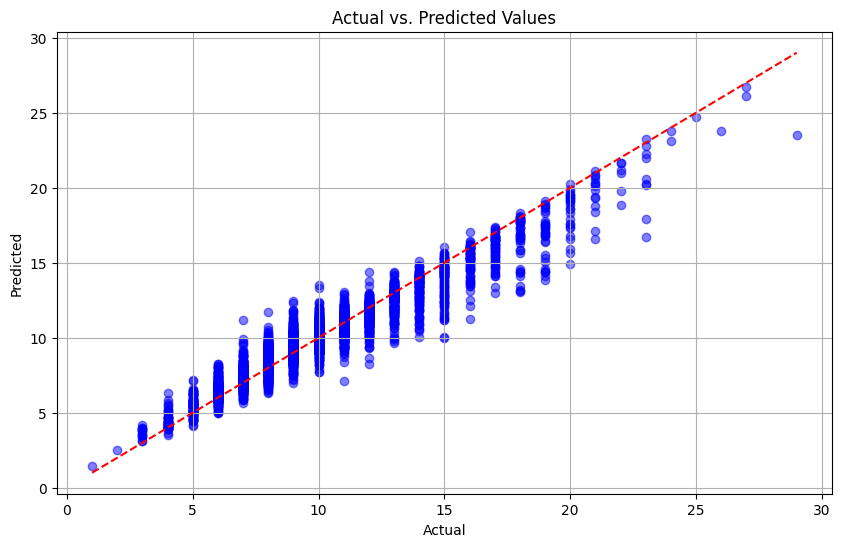

In [81]:
# Make predictions on the test set
y_pred = model.predict(X)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5, color='b')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted Values")

# Plot the diagonal line for reference
max_val = max(np.max(y), np.max(y_pred))
min_val = min(np.min(y), np.min(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='dashed')

plt.grid(True)
plt.show()

### <font color=red>NOTE:</font>

Even though we did not put much love into our model, the results are quite ok. However, please keep in mind, that you should start computing Shapley value if and only if you have optimized your model. You do not have to be a genius to understand that the better the model, the better the Shapley values. 

### Now, compute the Shaley values

These are the two essential lines of code. Pass your model into the SHAP Explainer function. 
This creates an explainer object. The, use this to calculate SHAP values for every observation in the feature matrix.

In [82]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

----------------------------------------------
### Visualization section
----------------------------------------------

#### Waterfall plot for first observation

There are 8 Shapley values for each of the 4177 observations in the feature matrix. 
That is one Shapley value for each feature in your model. You can use the waterfall function to visualise the Shapley values of the first observation.

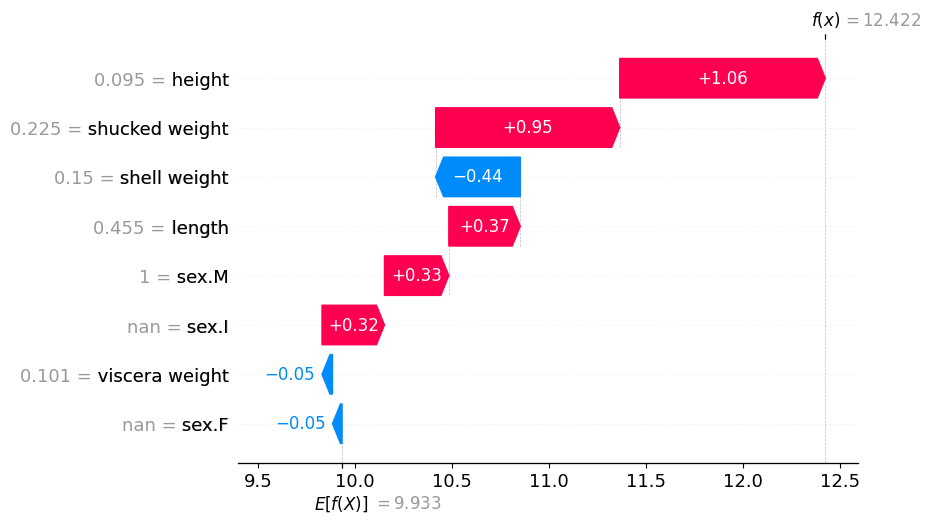

In [83]:
shap.plots.waterfall(shap_values[0])

##### <font color="ce33ff">Interpretation:</font>

**E[f(x)] = 9.933** gives the average predicted number of rings across all 4177 abalones. 
**f(x) = 13.043** is the predicted number of rings for this particular abalone. 
The Shapley values are all the values in between. 
For example, the shucked weight contributes to the total predicted number by an increase of **1.68**.

There is a unique waterfall plot for every observation of an abalone in your dataset. They can all be interpreted in the same way as above. In each case, the Shapley values tell us how the features have contributed to the prediction when compared to the average prediction. Large positive/negative values indicate that the feature had a significant impact on the model’s prediction.

#### Forceplot for first observation

In [84]:
shap.plots.force(shap_values[0])

##### <font color="ce33ff">Interpretation:</font>

Another way to visualise these individual feature contributions is using a so-called force plot. 
Think of it as a condensed waterfall plot. It starts at the same base value of **9.933** and you can see how each feature has contributed to the final prediction of **13.04**.

#### Entire/Stacked force plot

Waterfall and force plots are great for interpreting individual predictions (see above). To understand how your model makes predictions in general you need to aggregate the Shapley values. One way to do this is by using the so-called stacked-force plot.

You can combine multiple force plots together to create a stacked force plot. In this example pass the Shapley values for the first 100 observations in the force plot function. Each individual force plot is now vertical and stacked side by side.

Since this plot is interactive, you can change the ordering of the plots and choose which feature contributions to display.

In [85]:
shap.plots.force(shap_values[0:100])

##### <font color="ce33ff">Interpretation:</font>

For example, select "shell weight" on x-axis and "shell weight effects" on the y-axis.
Now, from the appearing plot you can see that as shell weight increases the Shapley values also increase. 
Since this is a function of age, older abalones tend to have heavier shells.

This is one way to understand the nature of the relationships captured by the model. 
Now, you will learn that the so-called beeswarm plot and dependence plots can also be used this way.

#### Mean SHAPLEY values

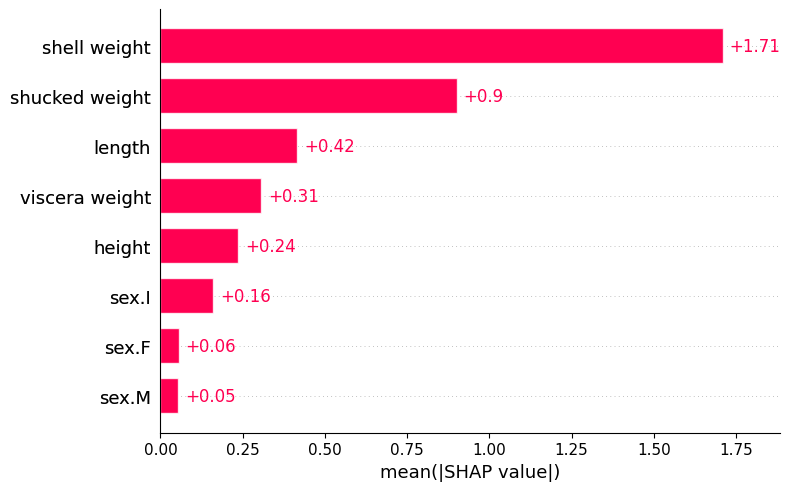

In [86]:
shap.plots.bar(shap_values)

##### <font color="ce33ff">Interpretation:</font>
This bar plot tells you which features are most important. 
For each and every feature, it calculates the mean Shapley value across all observations. 

Specifically, it takes the mean of the absolute values as it does not want positive and negative values to offset each other. 
There is one bar for each feature in the data set. You can easils see, that "shell weight" has the largest mean Shapley value.

Features that have made large positive/negative contributions will show a large mean Shapley value. In other words, these are the features that have had a significant impact on the model’s predictions. Hence, this bar plot can be used in the same manner as a feature importance plot.

#### Beeswarm plot

The so-called beeswarm plot is one of the most useful plots. The beeswarm visualises all of the SHAP values. 
On the y-axis, the values are grouped by feature. For each group, the colour of the points is determined by the feature value (i.e. higher feature values are more red - see legend ).

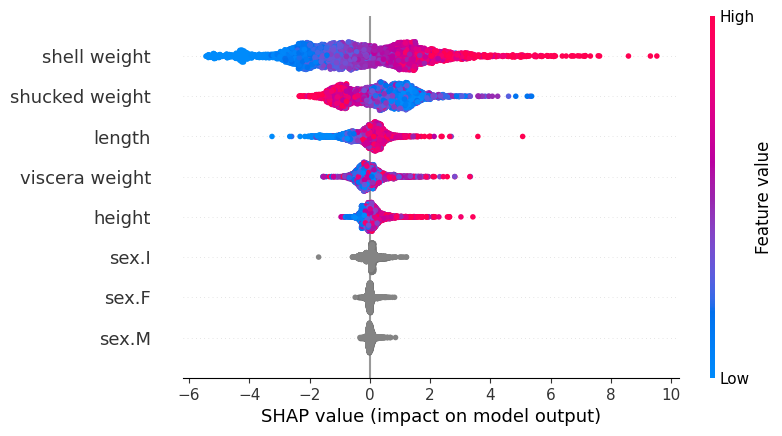

In [87]:
shap.plots.beeswarm(shap_values)

##### <font color="ce33ff">Interpretation:</font>

The features in the above plot are ordered by mean SHAP value.

E.g., for "shell weight", you will notice, that SHAP values increase when the feature value increases. 
Remember, you saw a similar relationship in the stacked force plot. It tells you that larger values for "shell weight" will lead to a higher predicted number of label value "rings".

You may also notice, that the feature "shucked weight" shows the opposite relationship. 
Looking at the beeswarm plot, we can see that larger values for this feature are associated with smaller SHAP values. 

##### Heatmap

Passing the matrix of 200 Shapley values to the heatmap plot function creates a plot with the instances on the x-axis, the model features on the y-axis, and the Shapley values encoded on a color scale. By default, the samples are ordered based on a hierarchical clustering by their explanation similarity. 
This results in samples that have the same model output for the same reason getting grouped together.

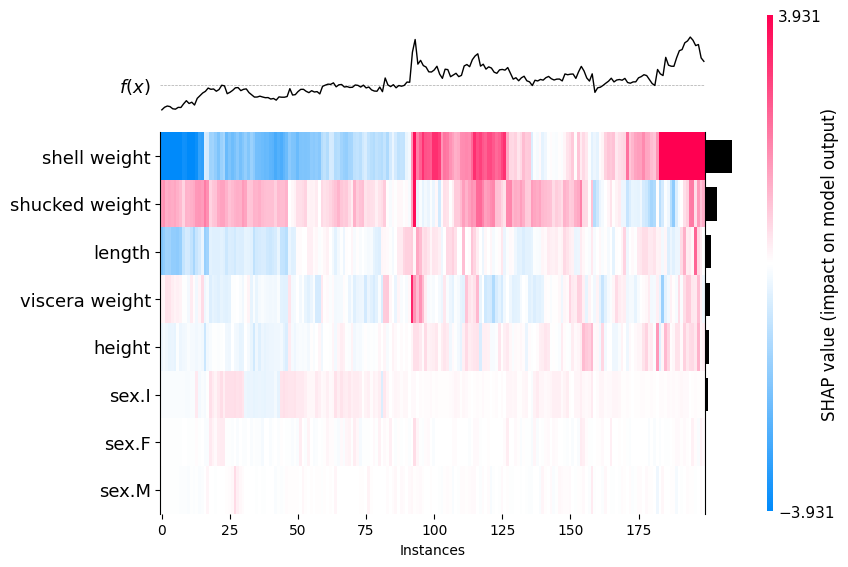

<Axes: xlabel='Instances'>

In [88]:
shap.plots.heatmap(shap_values[:200])

##### <font color="ce33ff">Interpretation:</font>

The output of the model is shown above the heatmap matrix (centered around the explaination’s average value), and the global importance of each feature shown as a bar plot on the right hand side of the plot (by default this is the average measure of overall importance).

#### Dependence plots of the Shapley values 

A dependence plot is a scatter plot of the Shapley value vs. the feature value for one single feature. 
They are particularly useful if the feature has got a non-linear relationship with the label.

##### Plot 1: shell weight

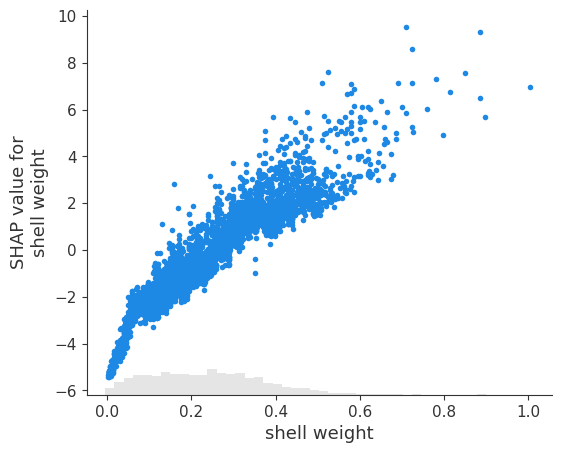

In [89]:
shap.plots.scatter(shap_values[:,"shell weight"])

##### <font color="ce33ff">Interpretation:</font>

For example, take the dependence plot for "shell weight" feature. 
Looking at the beeswarm plot we may have assumed that the Shapley values increase linearly with the feature value. 
However, this dependency plot shows you that the relationship is not perfectly linear. That is very useful.

##### Plot 2: shucked weight

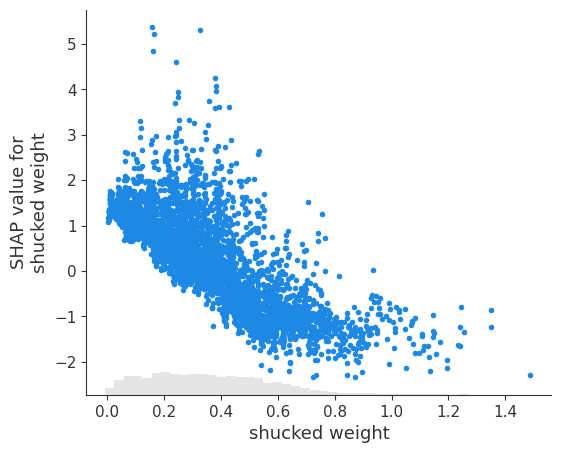

In [90]:
shap.plots.scatter(shap_values[:,"shucked weight"])

##### <font color="ce33ff">Interpretation:</font>
The dependency plot for "shucked weight" (i.e the weight of the abalone meat). 
Using this plot you can see and confirm the relationship you saw in the beeswarm plot already. 
The SHAP values do decrease as shucked weight increases.

##### Plot 3: shell weight & shucked weight

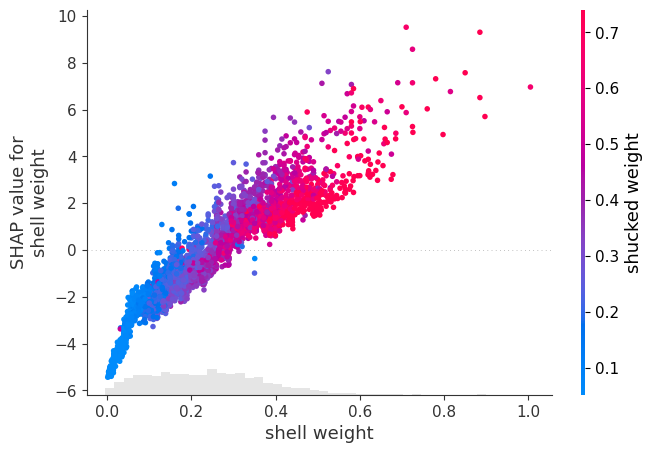

In [91]:
shap.plots.scatter(shap_values[:,"shell weight"],
                   color=shap_values[:,"shucked weight"])

##### <font color="ce33ff">Interpretation:</font>
This plot can be used to visualise interactions between features. BUT be cautious! 
In your case, the plot is a result of the correlation between the two features.

Intuitively, this relationship seems strange. 

Wouldn’t you expect an older abalone to be larger and having more meat? 

This is, in fact, a result of an interaction between "shell weight" and "shucked weight". 
You could not see it in the dependence plot due to the correlation. 

## 5. CNN on CIFAR-10 with SHAP
Now we will train a CNN on CIFAR-10 and explain it using SHAP.

In [92]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import shap
import numpy as np
import matplotlib.pyplot as plt

In [93]:
# Load CIFAR-10 data
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [94]:
# Build CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train Model
history = model.fit(train_images, train_labels, epochs=5, 
                    validation_data=(test_images, test_labels))

Epoch 1/5


2025-11-23 22:26:13.908809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - ETA: 0s - loss: 1.5314 - accuracy: 0.4397

2025-11-23 22:26:33.789899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 23s 14ms/step - loss: 1.5314 - accuracy: 0.4397 - val_loss: 1.3315 - val_accuracy: 0.5114
Epoch 2/5
1563/1563 [==============================] - 19s 12ms/step - loss: 1.1515 - accuracy: 0.5946 - val_loss: 1.0989 - val_accuracy: 0.6024
Epoch 3/5
1563/1563 [==============================] - 20s 13ms/step - loss: 0.9969 - accuracy: 0.6495 - val_loss: 0.9900 - val_accuracy: 0.6519
Epoch 4/5
1563/1563 [==============================] - 19s 12ms/step - loss: 0.8985 - accuracy: 0.6853 - val_loss: 0.9471 - val_accuracy: 0.6671
Epoch 5/5
1563/1563 [==============================] - 20s 12ms/step - loss: 0.8273 - accuracy: 0.7085 - val_loss: 0.8910 - val_accuracy: 0.6897


/Users/tly/Documents/GitHub/AML/AML/.venv/lib/python3.9/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/Users/tly/Documents/GitHub/AML/AML/.venv/lib/python3.9/site-packages/keras/backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(
2025-11-23 22:27:53.808204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-23 22:27:54.611555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-23 22:27:55.352460: I tensorflow/core/grap

1/1 [==============================] - 0s 112ms/step


2025-11-23 22:28:01.024129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Plotting SHAP values for the predicted classes...


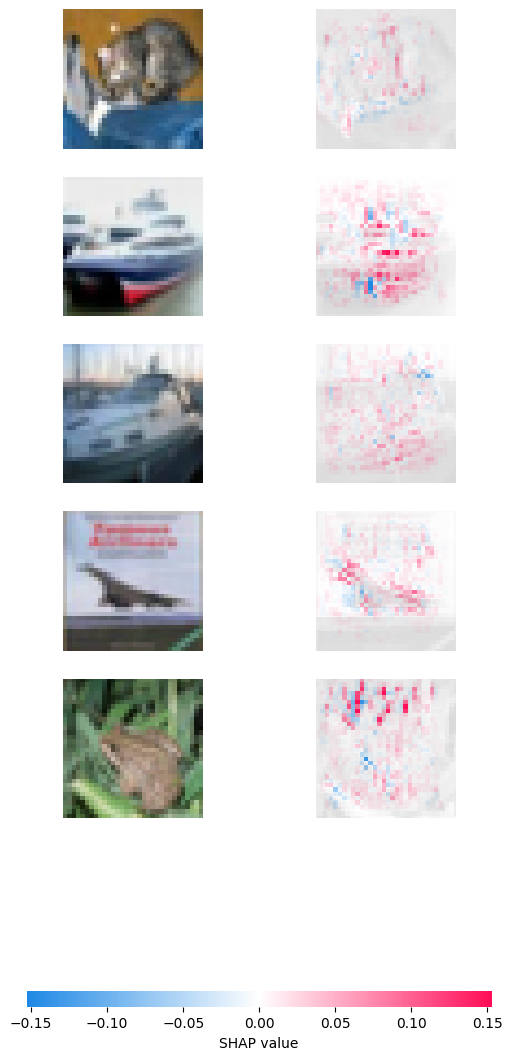

In [95]:
# SHAP Explanation
# 1. Select background (100 images)
background = train_images[np.random.choice(train_images.shape[0], 100, replace=False)]

# 2. Initialize DeepExplainer
explainer = shap.DeepExplainer(model, background)

# 3. Compute SHAP values for the first 5 test images
shap_values = explainer.shap_values(test_images[:5], check_additivity=False)

# 4. Visualize
predictions = model.predict(test_images[:5])
predicted_classes = np.argmax(predictions, axis=1)

# Select the SHAP values corresponding to the predicted class for each image
shap_val_selected = []
for i, pred_class in enumerate(predicted_classes):
    if isinstance(shap_values, list):
        # If shap_values is a list, it's usually [class][sample, ...]
        shap_val_selected.append(shap_values[pred_class][i])
    else:
        # If shap_values is an array, it's usually [sample, ..., class]
        # We assume the last dimension is the class.
        shap_val_selected.append(shap_values[i, ..., pred_class])

shap_val_selected = np.array(shap_val_selected)

# Plot
print("Plotting SHAP values for the predicted classes...")
shap.image_plot(shap_val_selected, test_images[:5])

### <font color="ce33ff">Observations: CNN SHAP Results</font>

#### 1. Pixel Region Importance

From the SHAP visualization results, we can observe that:

**Red regions (positive contribution)**: These pixels contribute positively to the model's prediction. They typically correspond to the core features of objects, such as cat's facial features (eyes, nose, ears), airplane's wings and fuselage, and vehicle body structures.

**Blue regions (negative contribution)**: These pixels negatively impact the prediction, often appearing in background areas or features similar to other classes.

#### 2. Feature Highlighting Accuracy

The DeepExplainer successfully identifies the most important pixel regions for classification decisions.

**Successful cases**: For cat images, SHAP correctly highlights facial features as the main contributors. For airplanes, the model focuses on wings and body contours rather than the sky background. For vehicles, SHAP values concentrate on the body shape and structure.

**Limitations**: Due to CIFAR-10's low resolution (32x32 pixels), some fine details are unclear. The model achieves 68.97% test accuracy with only 5 epochs of training, indicating room for improvement. Some background noise also receives SHAP values, possibly due to overfitting.

#### 3. Model Decision Reasonability

**Strengths**: The model focuses on objects rather than backgrounds, showing it has learned meaningful visual features. The highlighted regions align with human intuition for object recognition. Different classes show distinct SHAP heatmap patterns, indicating the model learned class-specific features.

**Limitations**: The low resolution limits the model's ability to capture fine-grained features. For similar classes (e.g., cat vs. dog, car vs. truck), the model may rely on less robust features.

### <font color="ce33ff">Comparison: XGBoost vs. CNN with SHAP</font>

#### Data Type and Feature Space

**XGBoost (Abalone dataset)**: Uses tabular data with 8 structured features. Each feature has clear physical meaning (e.g., shell weight, shucked weight). The feature space is low-dimensional and interpretable.

**CNN (CIFAR-10 dataset)**: Uses image data with 3072 pixels (32x32x3). Individual pixels have no independent meaning and must be understood in combination. The feature space is high-dimensional with raw pixel values.

#### SHAP Explanation Methods

**XGBoost with TreeExplainer**: Computation is efficient by leveraging tree structure. Results are exact (not approximate) for tree models. Feature interactions can be directly observed (e.g., shell weight and shucked weight). Visualizations include bar plots, beeswarm plots, waterfall plots, and dependence plots that are highly intuitive.

**CNN with DeepExplainer**: Computation is complex, requiring a background sample set and using the DeepLIFT approximation algorithm. SHAP values are approximate, requiring check_additivity=False. Generates pixel-level heatmaps showing which regions are important for predictions. Primary visualization is image_plot, overlaying importance on original images.

#### Interpretability Levels

**XGBoost**: Global interpretation is straightforward through mean SHAP values (e.g., "shell weight is the most important feature"). Local interpretation uses waterfall plots showing precise contribution of each feature to individual predictions. Causal relationships are clear (e.g., "shell weight increases leads to higher ring prediction").

**CNN**: Global interpretation is difficult since important pixel locations vary by class. Local interpretation is intuitive through image heatmaps (e.g., "for this cat image, the face contributes most to prediction"). Reveals spatial patterns learned by the model, but difficult to describe in simple language.

#### Practical Applications

**When to use XGBoost with SHAP**: Structured tabular data, need for precise feature contribution quantification, explaining model decisions to non-technical stakeholders, and feature engineering optimization.

**When to use CNN with SHAP**: Unstructured data like images or videos, need to visualize model attention regions, detect if the model learned incorrect features (e.g., background bias), and debug deep learning models.

**Conclusion**: Tabular models with XGBoost provide more interpretable numeric explanations suitable for quantitative analysis. Image models with CNN offer intuitive spatial visualizations revealing which regions the model focuses on for decisions.